<a href="https://colab.research.google.com/github/ninjamelons/TensorDNN/blob/master/Colabs_TPU_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import time
import os

import numpy as np
import pandas as pd
import json
import tensorflow as tf
from tensorflow.contrib.keras.api.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Input, LSTM, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
tf.__version__

Using TensorFlow backend.


'1.13.1'

In [0]:
data_dir = "D:/anoobis/uni/Notes/4th semester/PROJECT/data/import_data/"
max_words = 50000
max_len = 250
embedding_dim = 100
lstm_out = 100

In [3]:
from google.colab import files

print("Main data:")
uploaded = files.upload()

Main data:


Saving batched3.json to batched3.json


In [0]:
openfile=open('batched3.json')
jsondata=json.load(openfile)
df_source=pd.DataFrame(jsondata)
openfile.close()
df_source['label'] = df_source['categories'].apply(lambda x: x[0])

News: 6297
Twitter: 6156
Reddit: 3964


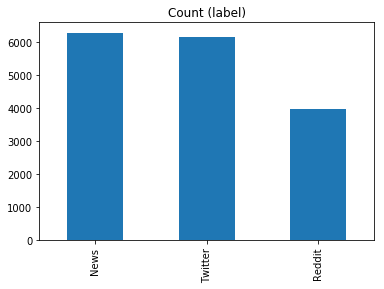

In [7]:
target_count = df_source.label.value_counts()
print('News:', target_count[0])
print('Twitter:', target_count[1])
print('Reddit:',target_count[2])

target_count.plot(kind='bar', title='Count (label)');

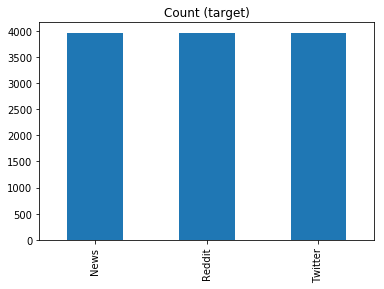

In [8]:
count_class_0, count_class_1, count_class_2 = df_source.label.value_counts()
df_class_0 = df_source[df_source['label']=='News']
df_class_1 = df_source[df_source['label']=='Twitter']
df_class_2 = df_source[df_source['label']=='Reddit']

df_class_0_under = df_class_0.sample(count_class_2)
df_class_1_under = df_class_1.sample(count_class_2)

df_balanced = pd.concat([df_class_0_under, df_class_1_under, df_class_2])

df_balanced.label.value_counts().plot(kind='bar', title='Count (target)');

In [0]:

text = df_balanced['text'].values
y = df_balanced['label'].values

sentences_train, sentences_test_val, categories_train, categories_test_val = train_test_split(text, y, test_size=0.30, random_state=1000)
sentences_test, sentences_validation, categories_test, categories_validation = train_test_split(sentences_test_val, categories_test_val, test_size=0.25, random_state=1000)

In [10]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(sentences_train)
label_encoder = LabelEncoder()
onehot_encoder = OneHotEncoder(sparse=False)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)
X_validation = tokenizer.texts_to_sequences(sentences_validation)

integer_encoded_categories_train = label_encoder.fit_transform(categories_train)
integer_encoded_categories_train = integer_encoded_categories_train.reshape(len(integer_encoded_categories_train), 1)
y_train = onehot_encoder.fit_transform(integer_encoded_categories_train)

integer_encoded_categories_test = label_encoder.fit_transform(categories_test)
integer_encoded_categories_test = integer_encoded_categories_test.reshape(len(integer_encoded_categories_test), 1)
y_test = onehot_encoder.fit_transform(integer_encoded_categories_test)

integer_encoded_categories_validation = label_encoder.fit_transform(categories_validation)
integer_encoded_categories_validation = integer_encoded_categories_validation.reshape(len(integer_encoded_categories_validation), 1)
y_validation = onehot_encoder.fit_transform(integer_encoded_categories_validation)

vocab_size = len(tokenizer.word_index) + 1

X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
X_test = pad_sequences(X_test, padding='post', maxlen=max_len)
X_validation = pad_sequences(X_validation, padding='post', maxlen=max_len)

KeyboardInterrupt: ignored

In [0]:
tf.keras.backend.clear_session()

def make_model(batch_size=None):
  model = Sequential()
  model.add(tf.keras.layers.Embedding(input_dim=vocab_size,
                      output_dim=embedding_dim,
                      input_length=max_len))
  model.add(tf.keras.layers.Conv1D(filters=48, kernel_size=3, padding='same', activation='relu'))
  model.add(tf.keras.layers.MaxPooling1D(pool_size=3))
  model.add(tf.keras.layers.LSTM(lstm_out, dropout=0.35, recurrent_dropout=0.35))
  #model.add(tf.keras.layers.LSTM(lstm_out, dropout=0.2))
  model.add(tf.keras.layers.Dense(3, activation='softmax'))
  model.compile(
      optimizer=tf.keras.optimizers.Adam(lr=0.001),
      loss=tf.keras.losses.CategoricalCrossentropy(),
      metrics=['accuracy'])
  return model

model = make_model(None)
model.summary()

In [0]:
# This address identifies the TPU we'll use when configuring TensorFlow.
TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
tf.logging.set_verbosity(tf.logging.INFO)

tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))

tpu_model.summary()

In [0]:
start_time = time.time()
history = tpu_model.fit(X_train, y_train,
                    batch_size=128,
                    epochs=50,
                    validation_data=(X_test, y_test))
print("--- %s seconds ---" % (time.time() - start_time))

In [0]:
loss, accuracy = tpu_model.evaluate(X_train, y_train)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = tpu_model.evaluate(X_test, y_test)
print("Testing Accuracy:  {:.4f}".format(accuracy))

In [0]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [0]:
plot_history(history)

In [0]:

test_one_twitter = tokenizer.texts_to_sequences(["Contemplating giving in to the iPhone bandwagon simply because #Cellcom has no new Androids #depressing #IDontWantTo"])
test_one_twitter = pad_sequences(test_one_twitter, padding='post', maxlen=max_len)

test_one_news = tokenizer.texts_to_sequences(["The legal action, filed in New York's Southern District, is against Deutsche Bank, one of Trump's lenders, and Capital One. Both banks \"have long provided business and personal banking services to Plaintiffs,\" Trump's attorneys said.\"The subpoenas were issued to harass President Donald J. Trump, to rummage through every aspect of his personal finances, his businesses, and the private information of the President and his family, and to ferret about for any material that might be used to cause him political damage. No grounds exist to establish any purpose other than a political one,\" Trump's attorneys wrote in the complaint filed late Monday."])
test_one_news = pad_sequences(test_one_news, padding='post', maxlen=max_len)

test_one_reddit = tokenizer.texts_to_sequences(["I paid a friend of mine some money to draw me a skin for Mercy I've always wanted. Yes, I know she's Swiss. No, I don't care. I wish it was a skin in game so I could ALWAYS USE IT. And against my better judgement I've posted it here to show off how good my friends art is. I hope y'all enjoy it, and if you don't, that's okay too ♥ Edit: She replied! https://www.instagram.com/jenv_arts/ and https://twitter.com/jenv_arts Enjoy everyone!"])
test_one_reddit = pad_sequences(test_one_reddit, padding='post', maxlen=max_len)

test_one_random = tokenizer.texts_to_sequences(["They dont need a product I've said it countless times there are groups that are just writing a report about analysing a data set using the exact same process we did in class Our product would be the code that cleaned and processed the data, the code that collected it, and hopefully if achievable the tensorflow program that trains a model to do something"])
test_one_random = pad_sequences(test_one_random, padding='post', maxlen=max_len)

test_one_aaaa = tokenizer.texts_to_sequences(["aaaaaaaaaaaaaaaaa aaaaaaa a aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa a aaaa aaaaaaaaaaaaaaaa aaaa aaaaaaaaaaaaaaaaaaaaaaaaa aaaaa aaaaaaaaaaaaaaaaaaaaaaa aa a aaaaaaaaaaaaaaaaa aaaaa aaaaa aaaaaaaaaaaaaaa aaa aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa a a a a aaaaaaaaaaa"])
test_one_aaaa = pad_sequences(test_one_aaaa, padding='post', maxlen=max_len)

In [0]:
test_one_twitter_8 = np.append(test_one_twitter, test_one_twitter, axis=0)
test_one_twitter_8 = np.append(test_one_twitter_8, test_one_twitter, axis=0)
test_one_twitter_8 = np.append(test_one_twitter_8, test_one_twitter, axis=0)
test_one_twitter_8 = np.append(test_one_twitter_8, test_one_twitter, axis=0)
test_one_twitter_8 = np.append(test_one_twitter_8, test_one_twitter, axis=0)
test_one_twitter_8 = np.append(test_one_twitter_8, test_one_twitter, axis=0)
test_one_twitter_8 = np.append(test_one_twitter_8, test_one_twitter, axis=0)

In [0]:
test_one_news_8 = np.append(test_one_news, test_one_news, axis=0)
test_one_news_8 = np.append(test_one_news_8, test_one_news, axis=0)
test_one_news_8 = np.append(test_one_news_8, test_one_news, axis=0)
test_one_news_8 = np.append(test_one_news_8, test_one_news, axis=0)
test_one_news_8 = np.append(test_one_news_8, test_one_news, axis=0)
test_one_news_8 = np.append(test_one_news_8, test_one_news, axis=0)
test_one_news_8 = np.append(test_one_news_8, test_one_news, axis=0)

In [0]:
test_one_random_8 = np.append(test_one_random, test_one_random, axis=0)
test_one_random_8 = np.append(test_one_random_8, test_one_random, axis=0)
test_one_random_8 = np.append(test_one_random_8, test_one_random, axis=0)
test_one_random_8 = np.append(test_one_random_8, test_one_random, axis=0)
test_one_random_8 = np.append(test_one_random_8, test_one_random, axis=0)
test_one_random_8 = np.append(test_one_random_8, test_one_random, axis=0)
test_one_random_8 = np.append(test_one_random_8, test_one_random, axis=0)

In [0]:
test_one_aaaa_8 = np.append(test_one_aaaa, test_one_aaaa, axis=0)
test_one_aaaa_8 = np.append(test_one_aaaa_8, test_one_aaaa, axis=0)
test_one_aaaa_8 = np.append(test_one_aaaa_8, test_one_aaaa, axis=0)
test_one_aaaa_8 = np.append(test_one_aaaa_8, test_one_aaaa, axis=0)
test_one_aaaa_8 = np.append(test_one_aaaa_8, test_one_aaaa, axis=0)
test_one_aaaa_8 = np.append(test_one_aaaa_8, test_one_aaaa, axis=0)
test_one_aaaa_8 = np.append(test_one_aaaa_8, test_one_aaaa, axis=0)

In [0]:
test_one_news_8.shape

In [0]:
test_one_random_8.shape

In [0]:
test_one_aaaa_8.shape

In [0]:
prediction = tpu_model.predict(X_validation)
x_label = ''
y_label = ''
j = 0
k = 2
for i in label_encoder.classes_:
  x_label += str(j) + " - " + i + "   "
  j += 1
for i in reversed(label_encoder.classes_):
  y_label += str(k) + " - " + i + "   "
  k -= 1

In [0]:

fig = sns.heatmap(confusion_matrix(
    y_validation.argmax(axis=1),
    np.round(prediction).argmax(axis=1)),
            annot=True,
            fmt='.5g')
plt.xlabel("Predicted: " + x_label)
plt.ylabel("Actual: " + y_label)


In [0]:
conf_mat = confusion_matrix(
    y_validation.argmax(axis=1),
    np.round(prediction).argmax(axis=1))
labels = ['News', 'Reddit', 'Twitter']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [0]:
prediction = tpu_model.predict(test_one_twitter_8)
for x in np.round(prediction, decimals=3):
    print("News: " + str(np.format_float_positional(x[0], pad_right=3)) + " | Reddit: " + str(np.format_float_positional(x[1], pad_right=3)) + " | Twitter: " + str(np.format_float_positional(x[2], pad_right=3)) + "\n")

In [0]:
prediction = tpu_model.predict(test_one_news_8)
for x in np.round(prediction, decimals=3):
    print("News: " + str(np.format_float_positional(x[0], pad_right=3)) + " | Reddit: " + str(np.format_float_positional(x[1], pad_right=3)) + " | Twitter: " + str(np.format_float_positional(x[2], pad_right=3)) + "\n")

In [0]:
prediction = tpu_model.predict(test_one_random_8)
for x in np.round(prediction, decimals=3):
    print("News: " + str(np.format_float_positional(x[0], pad_right=3)) + " | Reddit: " + str(np.format_float_positional(x[1], pad_right=3)) + " | Twitter: " + str(np.format_float_positional(x[2], pad_right=3)) + "\n")

In [0]:
prediction = tpu_model.predict(test_one_aaaa_8)
for x in np.round(prediction, decimals=3):
    print("News: " + str(np.format_float_positional(x[0], pad_right=3)) + " | Reddit: " + str(np.format_float_positional(x[1], pad_right=3)) + " | Twitter: " + str(np.format_float_positional(x[2], pad_right=3)) + "\n")